<a href="https://colab.research.google.com/github/venkateswara489/Machine-learning/blob/main/Feature_Engineering_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [1]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [26]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [4]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [5]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [6]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [7]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [8]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

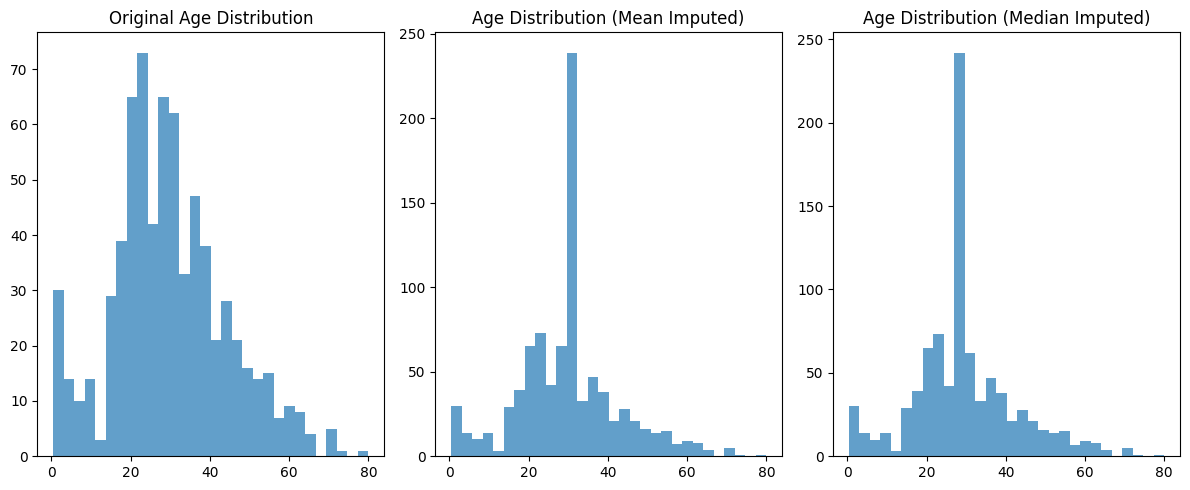

Comparison of Mean vs Median Imputation for Age:
Original Age Skew: 0.38910778230082704
Mean Imputed Age Skew: 0.4344880940129925
Median Imputed Age Skew: 0.5102446555756495

Median imputation usually preserves the original distribution better, especially if the data is skewed, as the median is less affected by outliers than the mean.

Comparison of Embarked Imputation:

Original Embarked value_counts():
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

Embarked value_counts() (Mode Imputed):
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

Embarked value_counts() ('Unknown' Imputed):
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

Filling with the mode increases the count of the most frequent category. Filling with 'Unknown' creates a new category and assigns the missing values to it.


In [17]:
# Exercise 2 - Solution

# 1. Compare mean vs median imputation for Age
age_mean_imputed = df['Age'].fillna(df['Age'].mean())
age_median_imputed = df['Age'].fillna(df['Age'].median())

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Age'].dropna(), bins=30, alpha=0.7)
plt.title('Original Age Distribution')

plt.subplot(1, 3, 2)
plt.hist(age_mean_imputed, bins=30, alpha=0.7)
plt.title('Age Distribution (Mean Imputed)')

plt.subplot(1, 3, 3)
plt.hist(age_median_imputed, bins=30, alpha=0.7)
plt.title('Age Distribution (Median Imputed)')

plt.tight_layout()
plt.show()

print("Comparison of Mean vs Median Imputation for Age:")
print("Original Age Skew:", df['Age'].skew())
print("Mean Imputed Age Skew:", age_mean_imputed.skew())
print("Median Imputed Age Skew:", age_median_imputed.skew())
print("\nMedian imputation usually preserves the original distribution better, especially if the data is skewed, as the median is less affected by outliers than the mean.")


# 2. For Embarked, try filling with a new category ('Unknown') vs mode. What changes in value_counts()?
embarked_mode_imputed = df['Embarked'].fillna(df['Embarked'].mode()[0])
embarked_unknown_imputed = df['Embarked'].fillna('Unknown')

print("\nComparison of Embarked Imputation:")
print("\nOriginal Embarked value_counts():")
print(df['Embarked'].value_counts(dropna=False))

print("\nEmbarked value_counts() (Mode Imputed):")
print(embarked_mode_imputed.value_counts(dropna=False))

print("\nEmbarked value_counts() ('Unknown' Imputed):")
print(embarked_unknown_imputed.value_counts(dropna=False))

print("\nFilling with the mode increases the count of the most frequent category. Filling with 'Unknown' creates a new category and assigns the missing values to it.")

## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

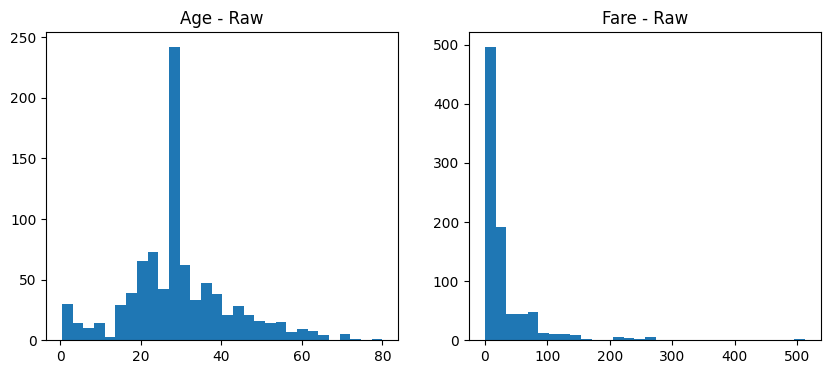

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

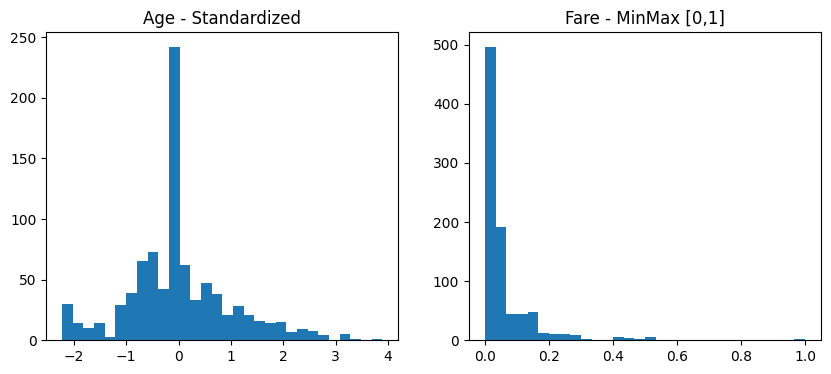

In [10]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

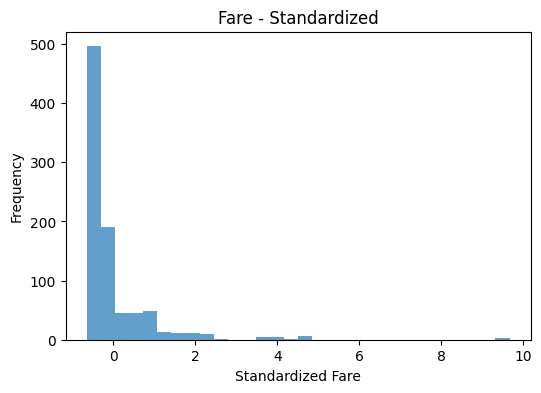

Descriptive statistics of Standardized Fare:
      count          mean       std       min       25%       50%       75%  \
Fare  891.0  3.987333e-18  1.000562 -0.648422 -0.489148 -0.357391 -0.024246   

           max  
Fare  9.667167  

First 5 normalized vectors of [Age, Fare]:
   Age_normalized  Fare_normalized
0        0.949757         0.312988
1        0.470417         0.882444
2        0.956551         0.291564
3        0.550338         0.834942
4        0.974555         0.224148


In [18]:
# Exercise 3 - Solution

# 1. Standardize Fare and plot the histogram
sc_std = StandardScaler()
fare_std = sc_std.fit_transform(df_imp[['Fare']])

plt.figure(figsize=(6, 4))
plt.hist(fare_std.flatten(), bins=30, alpha=0.7)
plt.title('Fare - Standardized')
plt.xlabel('Standardized Fare')
plt.ylabel('Frequency')
plt.show()

print("Descriptive statistics of Standardized Fare:")
print(pd.DataFrame(fare_std, columns=['Fare']).describe().T)

# 2. Apply Normalizer on [Age, Fare] rows and check the first 5 normalized vectors.
normalizer = Normalizer()
age_fare = df_imp[['Age', 'Fare']].dropna() # Drop NA for simplicity as Normalizer doesn't handle NaNs
age_fare_normalized = normalizer.fit_transform(age_fare)

print("\nFirst 5 normalized vectors of [Age, Fare]:")
print(pd.DataFrame(age_fare_normalized, columns=['Age_normalized', 'Fare_normalized']).head())

## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [ ]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

In [ ]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [19]:
# Exercise 4 - Solution

# 1. Compare the number of features produced by ordinal vs one-hot for Embarked.
# Ordinal encoding
enc = OrdinalEncoder()
embarked_ord = enc.fit_transform(df_imp[['Embarked']])
print(f"Number of features after Ordinal Encoding for Embarked: {embarked_ord.shape[1]}")

# One-Hot encoding
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
print(f"Number of features after One-Hot Encoding for Embarked: {ohe_embarked.shape[1]}")

# 2. Why might one-hot be safer for linear models?
print("\nWhy One-Hot Encoding might be safer for linear models:")
print("One-Hot encoding creates a new binary column for each category. This avoids introducing an artificial ordinal relationship between categories, which can be misleading for linear models that interpret numerical values as having magnitude and order. Linear models would incorrectly assume that one category is 'greater' or 'less' than another based on the assigned integer in ordinal encoding.")

Number of features after Ordinal Encoding for Embarked: 1
Number of features after One-Hot Encoding for Embarked: 3

Why One-Hot Encoding might be safer for linear models:
One-Hot encoding creates a new binary column for each category. This avoids introducing an artificial ordinal relationship between categories, which can be misleading for linear models that interpret numerical values as having magnitude and order. Linear models would incorrectly assume that one category is 'greater' or 'less' than another based on the assigned integer in ordinal encoding.


## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

In [ ]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

In [ ]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [ ]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

Skewness of numeric columns:
Fare           4.787317
SibSp          3.695352
Parch          2.749117
Age            0.510245
Survived       0.478523
PassengerId    0.000000
Pclass        -0.630548
dtype: float64


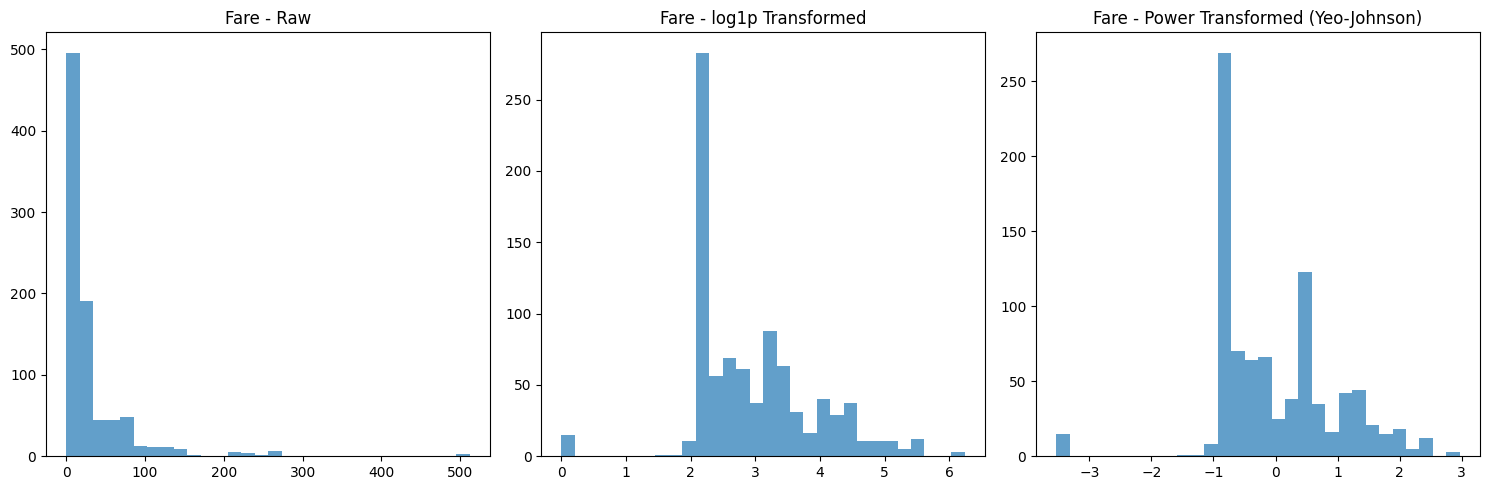


Comparison of Fare Distribution after Transforms:
Original Fare Skew: 4.787316519674893
Log1p Transformed Fare Skew: 0.3949280095189306
Power Transformed Fare Skew: -0.04032918275876422

New terms created by PolynomialFeatures(degree=2) from Age and Fare:
['Age' 'Fare' 'Age^2' 'Age Fare' 'Fare^2']

Explanation of terms:
- Age: Original Age feature.
- Fare: Original Fare feature.
- Age^2: Quadratic term of Age.
- Age * Fare: Interaction term between Age and Fare.
- Fare^2: Quadratic term of Fare.


In [20]:
# Exercise 5 - Solution

# 1. Identify one numeric column that is skewed. Try both log and power transforms and compare histograms.
# From the initial audit (df.describe().T), 'Fare' appears to be skewed.
# Let's confirm the skewness
print("Skewness of numeric columns:")
print(df_imp.select_dtypes(include=np.number).skew().sort_values(ascending=False))

# 'Fare' is highly skewed. Let's use 'Fare'.
fare_raw = df_imp['Fare'].values.reshape(-1, 1)

# Log transform (using log1p to handle zero values)
fare_log = np.log1p(fare_raw)

# Power transform (Yeo-Johnson since Fare includes zero)
pt = PowerTransformer(method='yeo-johnson')
fare_pt = pt.fit_transform(fare_raw)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(fare_raw.flatten(), bins=30, alpha=0.7)
plt.title('Fare - Raw')

plt.subplot(1, 3, 2)
plt.hist(fare_log.flatten(), bins=30, alpha=0.7)
plt.title('Fare - log1p Transformed')

plt.subplot(1, 3, 3)
plt.hist(fare_pt.flatten(), bins=30, alpha=0.7)
plt.title('Fare - Power Transformed (Yeo-Johnson)')

plt.tight_layout()
plt.show()

print("\nComparison of Fare Distribution after Transforms:")
print("Original Fare Skew:", df_imp['Fare'].skew())
print("Log1p Transformed Fare Skew:", pd.DataFrame(fare_log).skew().iloc[0])
print("Power Transformed Fare Skew:", pd.DataFrame(fare_pt).skew().iloc[0])


# 2. With PolynomialFeatures(2), which new terms are created from Age and Fare?
poly = PolynomialFeatures(degree=2, include_bias=False)
af = df_imp[['Age','Fare']].dropna() # Use the imputed data
poly.fit(af)

print("\nNew terms created by PolynomialFeatures(degree=2) from Age and Fare:")
print(poly.get_feature_names_out(['Age','Fare']))

print("\nExplanation of terms:")
print("- Age: Original Age feature.")
print("- Fare: Original Fare feature.")
print("- Age^2: Quadratic term of Age.")
print("- Age * Fare: Interaction term between Age and Fare.")
print("- Fare^2: Quadratic term of Fare.")

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

In [ ]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [21]:
# Exercise 6 - Solution

# 1. Which two numeric columns contribute the most variance before PCA?
# Use the imputed dataframe for variance calculation
numeric_df_imp = df_imp.select_dtypes(include=np.number)
variance = numeric_df_imp.var().sort_values(ascending=False)

print("Variance of numeric columns (descending):")
print(variance)
print("\nThe two numeric columns contributing the most variance are:")
print(variance.head(2))

# 2. Try PCA with n_components=3 and print the cumulative explained variance.
# Use the numeric-only dataframe, dropping NA for simplicity as done in the previous PCA example
num_only = df_imp.select_dtypes(include=['number']).dropna()

pca_3 = PCA(n_components=3, random_state=42)
pca_3.fit(num_only.values)

print("\nExplained variance ratios with PCA (n_components=3):")
print(pca_3.explained_variance_ratio_)

print("\nCumulative explained variance with PCA (n_components=3):")
print(np.sum(pca_3.explained_variance_ratio_))

Variance of numeric columns (descending):
PassengerId    66231.000000
Fare            2469.436846
Age              169.512498
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64

The two numeric columns contributing the most variance are:
PassengerId    66231.000000
Fare            2469.436846
dtype: float64

Explained variance ratios with PCA (n_components=3):
[0.96165195 0.03587775 0.0024362 ]

Cumulative explained variance with PCA (n_components=3):
0.9999659003439996


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).